# CPM Data Analysis with Python

This notebook uses Python to analyze the CPM data collected so far from GM counters in Vishnu's Montclair dental clinic and Lalit's Yorba Linda house.

### Import necessary packages.

In [1]:
%matplotlib inline
import os
import urllib3
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, writers
from IPython import display

### Create dataframes from files of CPM data.

In [2]:
def urltodf(xpat):
    xht = urllib3.PoolManager()
    xdf = xht.request('GET', xpat)
    xdf = xdf.data.decode('utf-8')
    xdf = xdf.split(',')
    xdf = list(filter(None, xdf))
    xdf = pd.DataFrame(xdf, columns=['Rec'])
    xdf['Ind'] = xdf['Rec'].apply(lambda x: len(x))
    xdf = xdf[xdf['Ind'] == 13]
    xdf['Cpm'] = xdf['Rec'].apply(lambda x: int(x[11:]))
    xdf['MDHMS'] = xdf['Rec'].apply(lambda x: int(x[:10]))
    xdf['MDHM'] = xdf['Rec'].apply(lambda x: int(x[:8]))
    xdf['MDH'] = xdf['Rec'].apply(lambda x: int(x[:6]))
    xdf['MD'] = xdf['Rec'].apply(lambda x: int(x[:4]))
    xdf['M'] = xdf['Rec'].apply(lambda x: int(x[:2]))
    xdf = xdf.sort_values(by=['MDHMS'], ascending=True)
    xdf = xdf.reset_index(drop=True)
    xdf['Ind'] = xdf.index
    return xdf

In [3]:
df1 = urltodf("https://lipy.us/data/2022_2_GMC_31164B313435D3_Montclair_3407_w11772.txt")
df2 = urltodf("https://lipy.us/data/2022_1_GMC_37074B313530AA_YorbaLinda_3389_w11780.txt")
df1.head()

,Rec,Ind,Cpm,MDHMS,MDHM,MDH,MD,M
0,0226175322 16,0,16,226175322,2261753,22617,226,2
1,0226175332 13,1,13,226175332,2261753,22617,226,2
2,0226175342 16,2,16,226175342,2261753,22617,226,2
3,0226175352 14,3,14,226175352,2261753,22617,226,2
4,0226175402 15,4,15,226175402,2261754,22617,226,2


### Make a folder for output files.

In [4]:
dou = "Outs"
mou = dou + "/CpmPlot.mp4"
pou = dou + "/CpmAggPlot.mp4"
if not os.path.exists(dou):
  os.makedirs(dou)
if os.path.exists(mou):
  os.remove(mou)
if os.path.exists(pou):
  os.remove(pou)

### Plot CPM data without saving.

In [5]:
df3 = df1[['Ind','Cpm']].merge(df2[['Ind','Cpm']], on='Ind', how='inner')
df3.head()

,Ind,Cpm_x,Cpm_y
0,0,16,16
1,1,13,16
2,2,16,16
3,3,14,17
4,4,15,15


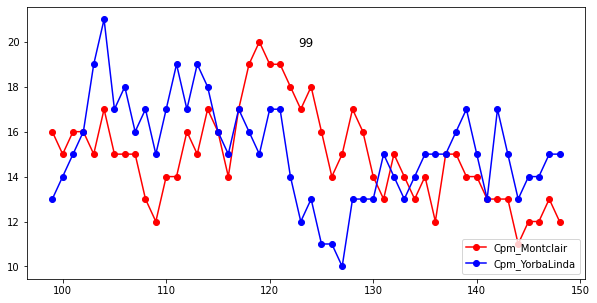

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

for i in range(100):
    try:
        dfx = df3.iloc[int(i):int(i+50)]['Ind']
        dfy1 = df3.iloc[int(i):int(i+50)]['Cpm_x']
        dfy2 = df3.iloc[int(i):int(i+50)]['Cpm_y']
        ax.cla()
        plt.plot(dfx, dfy1, color="red", marker="o")
        plt.plot(dfx, dfy2, color="blue", marker="o")
        plt.title(i)
        plt.legend(['Cpm_Montclair', 'Cpm_YorbaLinda'], bbox_to_anchor=(0.5,0.0,0.5,0.5), loc='lower right')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(0.01)
    except KeyboardInterrupt:
        break

### Prepare video file of the plot.

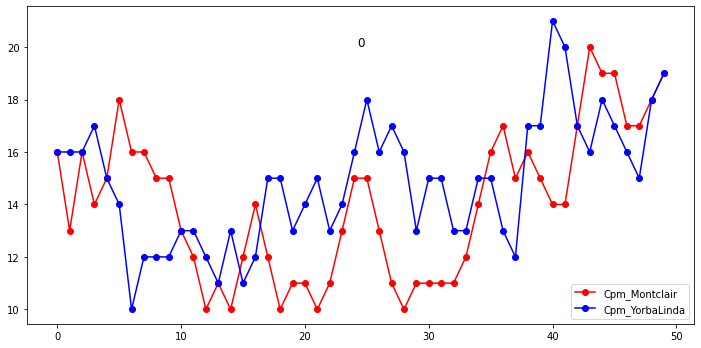

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.tight_layout()
plt.rcParams['axes.titley'] = 1.0
plt.rcParams['axes.titlepad'] = -40

def animate(i):
    try:
        dfx = df3.iloc[int(i):int(i+50)]['Ind']
        dfy1 = df3.iloc[int(i):int(i+50)]['Cpm_x']
        dfy2 = df3.iloc[int(i):int(i+50)]['Cpm_y']
        ax.cla()
        plt.plot(dfx, dfy1, color="red", marker="o")
        plt.plot(dfx, dfy2, color="blue", marker="o")
        plt.title(i)
        plt.legend(['Cpm_Montclair', 'Cpm_YorbaLinda'], bbox_to_anchor=(0.5,0.0,0.5,0.5), loc='lower right')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(0.01)
    except KeyboardInterrupt:
        return False

ani = FuncAnimation(fig, animate, frames=100, interval=0.1)
Writer = writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
ani.save(mou, writer=writer)

### Plot hourly means of CPM.

In [8]:
df1g = df1.groupby(['MDH']).mean()
df1g = df1g.reset_index()
df1g['Ind'] = df1g.index
df1g = df1g[['MDH','Cpm']]
df2g = df2.groupby(['MDH']).mean()
df2g = df2g.reset_index()
df2g['Ind'] = df2g.index
df2g = df2g[['MDH','Cpm']]
df1g.head()

,MDH,Cpm
0,22617,12.888889
1,22618,17.288184
2,22619,17.338150
3,22620,16.419825
4,22621,17.574344


In [9]:
df3g = df1g.merge(df2g, on='MDH', how='outer')
df3g['Cpm_x'].fillna(value=df3g['Cpm_x'].mean(), inplace=True)
df3g['Cpm_y'].fillna(value=df3g['Cpm_y'].mean(), inplace=True)
df3g['Ind'] = df3g.index
df3g.head()

,MDH,Cpm_x,Cpm_y,Ind
0,22617,12.888889,16.156897,0
1,22618,17.288184,16.156897,1
2,22619,17.338150,15.252252,2
3,22620,16.419825,16.156897,3
4,22621,17.574344,16.156897,4


In [10]:
print(df3g)

       MDH      Cpm_x      Cpm_y  Ind
0    22617  12.888889  16.156897    0
1    22618  17.288184  16.156897    1
2    22619  17.338150  15.252252    2
3    22620  16.419825  16.156897    3
4    22621  17.574344  16.156897    4
..     ...        ...        ...  ...
280  40616  16.560500  15.353982  280
281  40617  16.560500  15.997101  281
282  40618  16.560500  16.356287  282
283  40619  16.560500  15.567073  283
284  40620  16.560500  17.389140  284

[285 rows x 4 columns]


### Prepare image file of the plot.

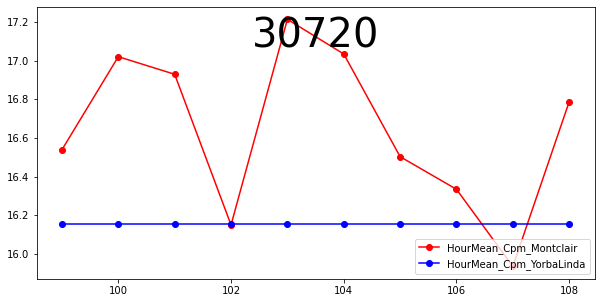

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

for i in range(100):
    try:
        dfx = df3g.iloc[int(i):int(i+10)]['Ind']
        dfy1 = df3g.iloc[int(i):int(i+10)]['Cpm_x']
        dfy2 = df3g.iloc[int(i):int(i+10)]['Cpm_y']
        ax.cla()
        plt.plot(dfx, dfy1, color="red", marker="o")
        plt.plot(dfx, dfy2, color="blue", marker="o")
        plt.title(df3g.iat[i,0], fontsize=40)
        plt.legend(['HourMean_Cpm_Montclair', 'HourMean_Cpm_YorbaLinda'], bbox_to_anchor=(0.5,0.0,0.5,0.5), loc='lower right')
        display.clear_output(wait=True)
        time.sleep(0.01)
    except KeyboardInterrupt:
        break

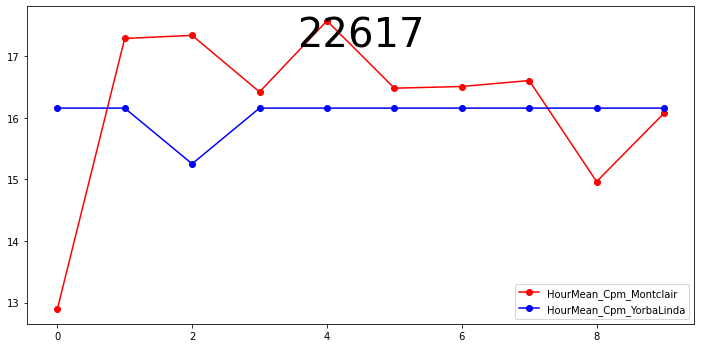

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.tight_layout()
plt.rcParams['axes.titley'] = 1.0
plt.rcParams['axes.titlepad'] = -40

def animatA(i):
    dfx = df3g.iloc[int(i):int(i+10)]['Ind']
    dfy1 = df3g.iloc[int(i):int(i+10)]['Cpm_x']
    dfy2 = df3g.iloc[int(i):int(i+10)]['Cpm_y']
    ax.cla()
    plt.plot(dfx, dfy1, color="red", marker="o")
    plt.plot(dfx, dfy2, color="blue", marker="o")
    plt.title(df3g.iat[i,0], fontsize=40)
    plt.legend(['HourMean_Cpm_Montclair', 'HourMean_Cpm_YorbaLinda'], bbox_to_anchor=(0.5,0.0,0.5,0.5), loc='lower right')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(0.01)

ani = FuncAnimation(fig, animatA, frames=100, interval=0.1)
Writer = writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
ani.save(pou, writer=writer)

### Conclusions

CPM data are random.

CPM data of the Montclair dental clinic are normal, indicating that the clinic does not have abnormal radiations.